## Question5: Online Q-learning with different layer sizes
Implement an online Q learning algorithm with a small neural net of 30 units for function approximation.

# Running this file
Run the until stopped and proceed as instucted


In [1]:
import sys
import math
import random
import pdb
import numpy as np
import tensorflow as tf
import gym
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import os
warnings.filterwarnings('ignore')

In [2]:
def get_q_optimize2(state,next_state, action, input_size , alpha, reward, discount):
    
    weights = {'hidden': tf.Variable(tf.random_uniform([input_size, 4], 0, 0.01)),
               'output': tf.Variable(tf.random_uniform([2, input_size], 0, 0.01))}
    biases = {'hidden': tf.Variable(tf.random_uniform([input_size,1], 0, 0.01)),
              'output': tf.Variable(tf.random_uniform([2,1], 0, 0.01))} 
    
    hidden = tf.nn.relu(tf.matmul(weights['hidden'], state) + biases['hidden'])
    #print(hidden.get_shape)
    q = tf.matmul(weights['output'], hidden) + biases['output']

    hidden = tf.nn.relu(tf.matmul(weights['hidden'], next_state) + biases['hidden'])
    q_prime = tf.matmul(weights['output'], hidden) + biases['output']

    delta = reward + 1   # don't boostrap if state is terminal (0 if terminal, 1 otherwise)
    
    target = reward + delta * discount * tf.stop_gradient(tf.reduce_max(q_prime))
    loss = tf.square(target - q[action,0])/2

    #opt = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6).minimize(loss)

    opt =tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return  q,opt,loss

In [3]:
# Training parameters
max_eps_length = 300
discount = 0.99
alpha = 0.001
n_episodes = 200
freq = n_episodes/100
epsilon = 0.05
sample_episodes = 10
episode_lengths = []
episode_returns = []

In [4]:
def eps_greed(q,counting,epsilon=0.05):
    u = np.random.uniform(0,1,1)
    if u <= epsilon:
        counting+=1

        if np.random.uniform(0,1,1)>0.5:
            act = 0
        else:
            act = 1
    else:
        act = np.argmax(q)
        
    return act, counting

# Do not run these cells...
Continue to load data below to load model and get return and length of episodes

In [6]:
# Need to save the model, weights and biases varibles

# Suggested Directory to use
save_MDir = 'new_models/A5_large/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

#save_model = os.path.join(save_MDir,'best_lr')

In [7]:
start = time.time()
sample_episodes = 15
n_episodes = 500
freq = n_episodes/100
count = 0
counting = 0    

# for each episode in 2000 episodes we optimize the q values. 
#print('----Starting iteration number: {}----'.format(iteration+1))
#start_iteration = time.time()

episode_loss = []
total_episode_lengths = []
total_episode_returns = []
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state = tf.placeholder("float", [4, 1])
action = tf.placeholder("int32", ())
next_state = tf.placeholder("float", [4, 1])
reward = tf.placeholder("float", ())
input_size = {'small' : 30, 'large' : 1000}

q,optimize,loss = get_q_optimize2(state, next_state,action,input_size['large'], alpha, reward, discount)

terminate_episode = False
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for i_episode in range(n_episodes):
        if i_episode % 100 == 0:
            print('Now runnning episode:{}'.format(i_episode))
            print('Total run time so far is: {}\n'.format(time.time()-start))
            if i_episode>0:
                print('last episode length {}'.format(np.mean(sample_episode_lengths)))
                if np.mean(sample_episode_lengths)>150:
                        print('Saving model...')
                        file_name = "A5_large%i.ckpt" %(int(alpha*100000))
                        save_model = os.path.join(save_MDir,file_name)
                        saver.save(sess= sess, save_path = save_model)
                        #print('model {} is the best yet!'.format(alpha)
        # Every 10 episodes we take 10 sample runs and report their average lengths
        if i_episode % freq == 0:
            
            sample_episode_lengths = []
            sample_episode_returns = []            
            for _ in range(sample_episodes):
                s = env.reset()
                for t in range(max_eps_length):
                    cur_q = sess.run(q, feed_dict={state:s.reshape(-1,1)})
                    a, counting = eps_greed(cur_q,counting)
                    s_prime,re,done,info = env.step(a)


                    if done:
                        #print('episode finished')
                        re = -1
                        sample_episode_lengths.append(t+1)
                        sample_episode_returns.append(-1*discount**t)
                        break

                    s = s_prime
            total_episode_lengths.append(np.mean(sample_episode_lengths))
            total_episode_returns.append(np.mean(sample_episode_returns))

                

        s = env.reset()
        for t in range(max_eps_length):
            cur_q = sess.run(q, feed_dict={state:s.reshape(-1,1)})
            a, counting = eps_greed(cur_q,counting)
            s_prime,re,done,info = env.step(a)

            if done:
                re = -1
                episode_lengths.append(t+1)
                episode_returns.append(-1*discount**t)
                terminate_episode = True
            else:
                re = 0

            this_dict = {state:s.reshape(-1,1), next_state:s_prime.reshape(-1,1), action:a, reward:re}
            opt, ls = sess.run([optimize,loss],this_dict)

            if  terminate_episode == True:
                count +=1
                terminate_episode = False
                break
            s = s_prime
        if i_episode %freq == 0:
                episode_loss.append(ls)
   
    if np.mean(sample_episode_lengths)>150:
        print('Saving model...')
        file_name = "A5_large%i.ckpt" %(int(alpha*100000))
        save_model = os.path.join(save_MDir,file_name)
        saver.save(sess= sess, save_path = save_model)
#     print('Saving model...')
#     file_name = 'large_model'
#     save_model = os.path.join(save_MDir,file_name)
#     saver.save(sess= sess, save_path = save_model)
#     print('model {} is the best yet!'.format(alpha))
    #saver.save(sess= sess, save_path = save_model)

total_episode_lengths = np.asarray(total_episode_lengths).reshape(-1,1)
total_episode_returns = np.asarray(total_episode_returns).reshape(-1,1)
episode_loss = np.asarray(episode_loss).reshape(-1,1)

saved_data  = np.concatenate((total_episode_lengths, total_episode_returns, episode_loss), axis=1)
filename = './results/A5_large_results.csv'
np.savetxt(filename, saved_data, delimiter=' ,')
print('Total run time is: {}'.format(time.time()-start))

[2017-04-06 22:16:24,073] Making new env: CartPole-v0


Now runnning episode:0
Total run time so far is: 0.359938383102417

Now runnning episode:100
Total run time so far is: 3.8430333137512207

last episode length 41.2
Now runnning episode:200
Total run time so far is: 7.8868067264556885

last episode length 27.8
Now runnning episode:300
Total run time so far is: 28.05443572998047

last episode length 95.46666666666667
Now runnning episode:400
Total run time so far is: 50.90023159980774

last episode length 56.333333333333336
Saving model...
Total run time is: 78.5181040763855


In [8]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


20.0


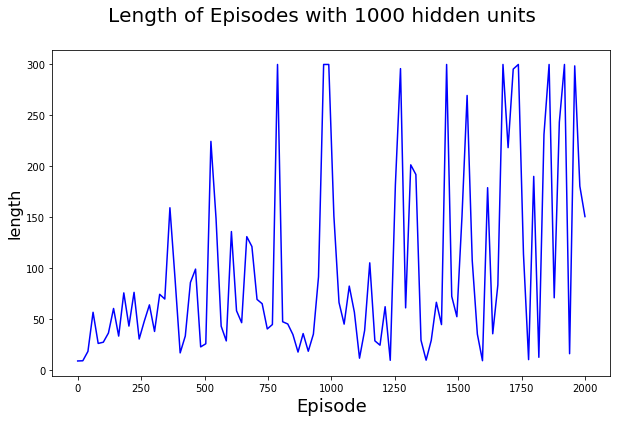

In [11]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,0],'b')# plotting t,a separately 

fig.suptitle('Length of Episodes with 1000 hidden units', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('length', fontsize=16)
plt.show()
#fig.savefig('./results/pics/A5_large_lengths.jpg')

20.0


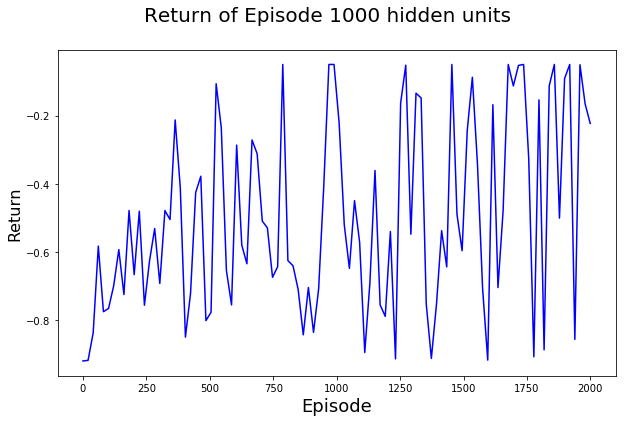

In [12]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
print(freq)
plt.plot(t,saved_data[:,1],'b')# plotting t,a separately 

fig.suptitle('Return of Episode 1000 hidden units', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.show()
#fig.savefig('./results/pics/A5_large_returns.jpg')

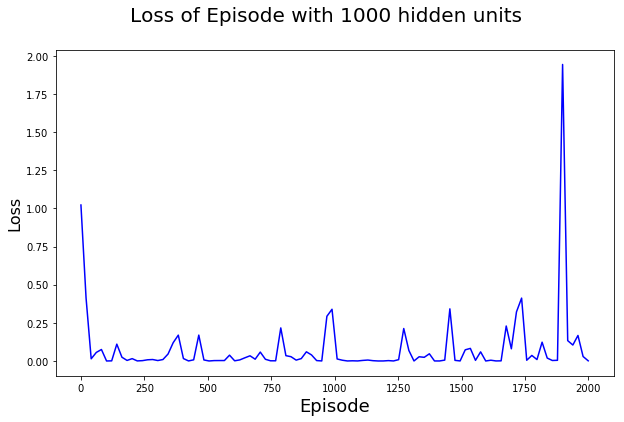

In [13]:
t = np.linspace(0,n_episodes-1,n_episodes/freq)
fig = plt.figure()
plt.plot(t,saved_data[:,2],'b')# plotting t,a separately 

fig.suptitle('Loss of Episode with 1000 hidden units', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Episode', fontsize=18)
plt.ylabel('Loss', fontsize=16)
plt.show()
#fig.savefig('./results/pics/A5_large_loss.jpg')

# Load Model
Load the model of the best learning rate. Output the Average return and episode length

In [10]:
save_MDir = 'new_models/A5_try/'

file_name = "A5_small%i.ckpt" %(int(alpha*100000))
save_model = os.path.join(save_MDir,file_name)
input_size = {'small' : 30, 'large' : 1000}
#save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
print(save_model)

new_models/A5_try/A5_small100.ckpt


In [11]:
def test_epoch(sess, test_episodes):   
    e_length = []
    e_return = []
    av_len = []
    av_ret = []
    for _ in range(test_episodes):
        s = env.reset()
        
        for t in range(300):
            this_q = sess.run(q, feed_dict={state: s.reshape(4, 1)})
            #ac_greedily
            a = np.argmax(this_q)

            s_prime, rwd, done, info = env.step(a)

            if done:
                e_length.append(t+1)
                e_return.append(-1 * discount**t)
                break
            s = s_prime

    #av_len.append(np.mean(np.array(episode_length)))
    #av_ret.append(np.mean(np.array(episode_return)))
    return e_length, e_return

In [13]:
tf.reset_default_graph()
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state = tf.placeholder("float", [4, 1])
action = tf.placeholder("int32", ())
next_state = tf.placeholder("float", [4, 1])
reward = tf.placeholder("float", ())
input_size = 30
alpha = 0.001

q,optimize,loss = get_q_optimize2(state, next_state,action,30, alpha, reward, discount)

init  = tf.global_variables_initializer()
test_episodes = 50
"""---------------- restore model after training  --------------------------"""
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    print(save_model)
    saver.restore(sess = sess, save_path= save_model)
    print("Restored values for learning rate: ",alpha)
    restored_length, restored_return = test_epoch(sess,50)
    print('The average length of episode is: {} with std: {} '.format(np.mean(restored_length),np.std(restored_length)))
    print('The average return of episode is: {} with std: {} '.format(np.mean(restored_return),np.std(restored_return)))


[2017-04-08 14:18:52,232] Making new env: CartPole-v0


new_models/A5_try/A5_small100.ckpt
Restored values for learning rate:  0.001
The average length of episode is: 300.0 with std: 0.0 
The average return of episode is: -0.049536256637662354 with std: 6.938893903907228e-18 
